In [5]:
import os,sys
if os.path.exists("/home/cloud-user/python-esp"):
    sys.path.append("/home/cloud-user/python-esp")
    import esppy
    print("INFO: ESPPY - Loaded & ready to be used")
else:
    print("ERROR: Cannot Load ESPPY!")

INFO: ESPPY - Loaded & ready to be used


In [4]:
import pandas as pd
import time
import matplotlib.pyplot as plt

In [8]:
esp = esppy.ESP('http://ESPhost:ESPPort')
print(f"INFO: We are now hooked into a running ESP server :- {esp}")

INFO: We are now hooked into a running ESP server :- ESP('http://esp52.dept-crp.sashq-r.openstack.sas.com:60011')


In [9]:
esp.server_info

{'version': '5.2',
 'engine': 'esp',
 'analytics-license': True,
 'pubsub': 60001,
 'http': 60011,
 'plugindir': '/opt/sas/viya/home/SASFoundation/sasexe'}

In [10]:
proj = esp.create_project('sir_fred_retail')

In [11]:
src = esp.SourceWindow(schema=('id*:int64', 'image:blob'),
                       index_type='empty', 
                       insert_only=True)
proj.windows['w_data'] = src

In [13]:
resize = esp.calculate.ImageProcessing(schema=('id*:int64', '_image_:blob'), function="resize", width=224, height=224)
resize.set_inputs( imageInput='image:blob')
resize.set_outputs( imageOutput='_image_:blob')
proj.windows['resized'] = resize

In [15]:
#define a request window to inject the astore model to the reader window
model_request = esp.SourceWindow(schema=('req_id*:int64', 'req_key:string', 'req_val:string'),
                                index_type='empty', insert_only=True)
proj.windows['w_request'] = model_request

In [16]:
#define a model reader window
model_reader = esp.ModelReaderWindow()
proj.windows['w_reader'] = model_reader

In [17]:
model_score = esp.ScoreWindow(schema=('id*:int64',
                               'I__label_:string',
                               'P__label_shirt:double',
                                'P__label_dress:double',
                                'P__label_handbag:double',
                                'P__label_sunglasses:double',
                                'P__label_trouser:double'))
 
model_score.add_offline_model(model_type='astore')
proj.windows['w_score'] = model_score

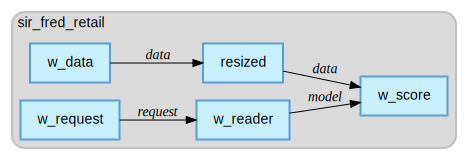

In [18]:
src.add_target( resize, role='data')
resize.add_target( model_score, role='data')
model_request.add_target( model_reader, role='request')
model_reader.add_target( model_score, role='model')
proj.to_graph()

## Load up the model and test it!

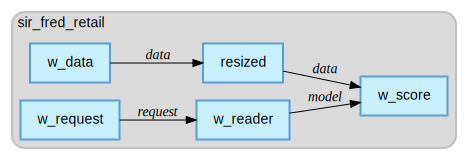

In [19]:
esp.load_project(proj)

In [20]:
esp.get_projects()

{'sir_fred_retail': Project(name='sir_fred_retail')}

In [21]:
# load the model
pub = model_request.create_publisher(blocksize=1, rate=0, pause=0,
                                     dateformat='%Y%m%dT%H:%M:%S.%f', opcode='insert', format='csv')
strToSend = 'i,n,1,"action","load"\n'
pub.send(strToSend)
 
strToSend = 'i,n,2,"type","astore"\n'
pub.send(strToSend)
 
strToSend = 'i,n,3,"reference","/home/cloud-user/race_img_bkp_full/s_Img_Recognition/vgg16_notop.astore"\n'
pub.send(strToSend)
 
strToSend = 'i,n,4,,\n'
pub.send(strToSend)

In [23]:
# We now have a running esp server and our model is deployed. 
# The next step is to create a publisher and publish some images to the server for scoring. 
# We are also subscribing to the model_score window to get the results back.
 
# create a publisher for scoring
pub = src.create_publisher(blocksize=1, rate=0, pause=0,
                               dateformat='%Y%m%dT%H:%M:%S.%f', opcode='insert', format='csv')
# subscribing to the model_score window to get the results back.
model_score.subscribe()

Time to check if the scoring works ok!

Our Example is a dress


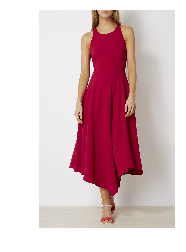

In [6]:
import cv2
import base64
img = cv2.imread('/home/cloud-user/race_img_bkp_full/s_Img_Recognition/00000001.jpg')
print(f"Our Example is a dress")
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

In [25]:
returnvalue, array_in_buffer = cv2.imencode('.jpg',f)
encoded_string = base64.b64encode( array_in_buffer)

strToSend = "i,n,1,"+encoded_string.decode()+"\n";
pub.send( strToSend)

In [42]:
get_cols =[i for i in model_score.tail(1).columns if model_score.tail(1)['I__label_'].values[0].strip() in i]
get_cols.append('I__label_')
get_cols

['P__label_dress', 'I__label_']

In [43]:
#model_score.tail(1).iloc[:,1:]
model_score.tail(1)[get_cols]

,P__label_dress,I__label_
id,,
1,1.0,dress


In [49]:
### Finally lets save the model xml so we can use it for production
proj.save_xml('/home/cloud-user/race_img_bkp_full/s_Img_Recognition/sir_fred_retail.xml')